## Assignment - part 2

Now that we have a better understanding of how to set up a basic neural network in Tensorflow, let's see if we can convert our dataset to a classificiation problem, and then rework our neural network to solve it. I will replicate most of our code from the previous assignment below, but leave blank spots where you should implement changes to convert our regression model into a classification one. Look for text descriptions above code blocks explaining the changes that need to be made, and `#UPPERCASE COMMENTS` where the new code should be written.

In [53]:
%matplotlib inline
import math
import random

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_boston

'''Since this is a classification problem, we will need to 
represent our targets as one-hot encoding vectors (see previous lab).
To do this we will use scikit-learn's OneHotEncoder module 
which we import here'''
from sklearn.preprocessing import OneHotEncoder

import numpy as np
import tensorflow as tf

sns.set(style="ticks", color_codes=True)

### 1. Target data format

The first step is to change the target of the dataset from a continuous variable (the value of the house) to a categorical one. In this case we will change it to have two categories, specifying whether the value of the house is higher or lower than the average.

In the code block below, write code to change the ‘target’ column to a categorical variable instead of a continuous one. This variable should be 1 if the target is higher than the average value, and 0 if it is lower. You can use np.mean() to calculate the average value. Then, you can iterate over all entries in the column, and compare each value to the average to decide if it is higher or lower. Finally, you can use the int() function to convert the True/False values to 0 and 1.

In [54]:
dataset = load_boston()
houses = pd.DataFrame(dataset.data, columns=dataset.feature_names)
houses['target'] = dataset.target
averageValue=np.mean(houses.target)

houses['target'] = (dataset.target > averageValue).astype(int)

# WRITE CODE TO CONVERT 'TARGET' COLUMN FROM CONTINUOUS TO CATEGORICAL

In [55]:
'''check your work'''
print np.max(houses['target']), "<-- should be 1"
print np.min(houses['target']), "<-- should be 0"

1 <-- should be 1
0 <-- should be 0


### 2. Target data encoding

Since we are now dealing with a classification problem, our target values need to be encoded using one-hot encoding (OHE) (see Lab 3 for a description of what this is and why it's necessary). In the code block below, use scikit-learn's `OneHotEncoder()` module to ocnvert the y target array to OHE.

_hint_: when you create the onehotencoder object, pass in the variable sparse=false to give the resulting data the proper formatting each value in y should be a two-part array, either [0,1] or [1,0] depending on the target value.

In [56]:
houses_array = houses.as_matrix().astype(float)
np.random.shuffle(houses_array)

X = houses_array[:, :-1]
y = houses_array[:, -1]

print(y.shape)
y = y.reshape(-1,1)
print(y[0])
enc = OneHotEncoder(sparse=False)
y = enc.fit_transform(y)
print(y[0])

# USE SCIKIT-LEARN'S ONE-HOT ENCODING MODULE TO 
# CONVERT THE y ARRAY OF TARGETS TO ONE-HOT ENCODING.

X = X / X.max(axis=0)

trainingSplit = int(.7 * houses_array.shape[0])
X_train = X[:trainingSplit]
y_train = y[:trainingSplit]
X_test = X[trainingSplit:]
y_test = y[trainingSplit:]

print('Training set', X_train.shape, y_train.shape)
print('Test set', X_test.shape, y_test.shape)

(506,)
[ 1.]
[ 0.  1.]
('Training set', (354, 13), (354, 2))
('Test set', (152, 13), (152, 2))


In [57]:
'''check your work'''
print y_train.shape[1], "<-- should be 2"
print y_test.shape[1], "<-- should be 2"
print y_train[0], "<-- should be either [0. 1.] or [1. 0.]"

2 <-- should be 2
2 <-- should be 2
[ 0.  1.] <-- should be either [0. 1.] or [1. 0.]


In [58]:
# helper variables
num_samples = X_train.shape[0]
num_features = X_train.shape[1]
num_outputs = y_train.shape[1]

# Hyper-parameters
batch_size = 15
num_hidden_1 = 12
num_hidden_2 =  12
learning_rate =  0.2
training_epochs =  500
dropout_keep_prob = 1 # 0.5 # set to no dropout by default

# variable to control the resolution at which the training results are stored
display_step = 1

### 3. Perfomance measure

Instead of measuring the average error in the prediction of a continuous variable, we now want our performance measure to be the number of samples for which we guess the right category.

As before, this function takes in an array of predictions and an array of targets. This time, however, each prediction or target is represented by a two-piece array. With the predictions, the two values represent the confidence of the system for choosing either value as the category. Because these predictions are generated through the [softmax function](https://en.wikipedia.org/wiki/Softmax_function), they are guaranteed to add up to 1.0, so they can be interpreted as the percentage of confidence behind each category. In our two category example,

- A prediction of [1,0] means complete confidence that the sample belongs in the first category
- A prediction of [0,1] means complete confidence that the sample belongs in the second category
- A prediction of [0.5,0.5] means the system is split, and cannot clearly decide which category the sample belongs to.

With the targets, the two values are the one-hot encodings generated previously. You can now see how the one-hot encoding actually represents the target values in the same format as the predictions coming from the model. This is helpful because while the model is training all it has to do is try to  match the prediction arrays to the encoded targets. Infact, this is exactly what our modified cost function will do.

For our accuracy measure, we want to take these two arrays of predictions and targets, see how many of them match (correct classification), then devide by the total number of predictions to get the ratio of accurate guesses, and multiply by 100.0 to convert it to a percentage.

_hints:_ 

- numpy's np.argmax() function will give you the position of the largest value in the array along an axis, so executing np.argmax(predictions, 1) will convert the confidence measures to the single most likely category.
- once you have a list of single-value predictions, you can compare them using the '==' operator to see how many match (matches result in a 'True' and mismatches result in a 'False')
- you can use numpy's np.sum() function to find out the total number of 'True' statements, and divide them by the total number of predictions to get the ratio of accurate predictions.

In [59]:
def accuracy(predictions, targets):
    
    # IMPLEMENT THE NEW ACCURACY MEASURE HERE
    max_pred = np.argmax(predictions,1)
    max_target = np.argmax(targets,1)
    accuracy = np.sum((max_pred==max_target))/float(max_pred.shape[0])*100.0 
    return accuracy

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

### 4. Model definition

For the most part, our model definition will stay roughtly the same. The major difference is that the final layer in our network now contains two values, which are interpreted as the confidence that the network has in classifying each input set of data as belonging to either the first or second category. 

However, as the raw output of the network, these outputs can take on any value. In order to interpret them for categorization it is typical to use the softmax function, which converts a range of values to a probability distribution along a number of categories. For example, if the outputs from the network from a given input are [1,000,000 and 10], we would like to interpret that as [0.99 and 0.01], or almost full confidence that the sample belongs in the first category. Similarly, if the outputs are closer together, such as 10 and 5, we would like to interpret it as something like [0.7 and 0.3], which shows that the first category is still more likely, but it is not as confident as before. This is exactly what the softmax function does. The exact formulation of the softmax function is not so important, as long as you know that the goal is to take the raw outputs from the neural network, and convert them to a set of values that preserve the relationship between the outputs while summing up to 1.0.

To adapt our code for classification, we simply have to wrap all of our outputs in a `tf.nn.softmax()` function, which will convert the raw outputs to confidence measures. We will also replace the MSE error function with a cross-entropy function which performs better with classification tasks. Look for comments below for implementation details.

In [60]:
graph = tf.Graph()

with graph.as_default():
    
    x = tf.placeholder(tf.float32, shape=(None, num_features))
    _y = tf.placeholder(tf.float32, shape=(None))
    
    keep_prob = tf.placeholder(tf.float32)
    
    tf_X_test = tf.constant(X_test, dtype=tf.float32)
    tf_X_train = tf.constant(X_train, dtype=tf.float32)
    
    
    W_fc1 = weight_variable([num_features, num_hidden_1])
    b_fc1 = bias_variable([num_hidden_1])
    
    W_fc2 = weight_variable([num_hidden_1, num_hidden_2])
    b_fc2 = bias_variable([num_hidden_2])
    
    W_fc3 = weight_variable([num_hidden_2, num_outputs])
    b_fc3 = bias_variable([num_outputs])
    
    
    def model(data, keep):
        
        fc1 = tf.nn.sigmoid(tf.matmul(data, W_fc1) + b_fc1)
        fc1_drop = tf.nn.dropout(fc1, keep)
        
        fc2 = tf.nn.sigmoid(tf.matmul(fc1_drop, W_fc2) + b_fc2)
        fc2_drop = tf.nn.dropout(fc2, keep)
        
        fc3 = tf.matmul(fc2_drop, W_fc3) + b_fc3
        
        return fc3
    
    '''for our loss function we still want to get the raw outputs 
    of the model, but since it no longer represents the actual prediction 
    we rename the variable to ‘output’'''
    output = model(x, keep_prob)
    
    # WHEN WE CALCULATE THE PREDICTIONS, WE NEED TO WRAP EACH OUTPUT IN A
    # tf.nn.softmax() FUNCTION. THE FIRST ONE HAS BEEN DONE FOR YOU:
    prediction = tf.nn.softmax(output)
    test_prediction = model(tf_X_test, 1.0)
    train_prediction = model(tf_X_train, 1.0)
    
    '''finally, we replace our previous MSE cost function with the
    cross-entropy function included in Tensorflow. This function takes in the
    raw output of the network and calculates the average loss with the target'''
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(output, _y))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    saver = tf.train.Saver()

Now that we have replaced the relevant accuracy measures and loss function, our training process is exactly the same, meaning we can run the same training process and plotting code to visualize the results. The only difference is that with classificiation we are using an accuracy rather than an error measure, so the better our model is performing, the higher the graph should be (higher accuracy is better, while lower error is better).

In [61]:
results = []

with tf.Session(graph=graph) as session:
    
    tf.initialize_all_variables().run()
    print('Initialized')

    for epoch in range(training_epochs):
        
        indexes = range(num_samples)
        random.shuffle(indexes)
        
        for step in range(int(math.floor(num_samples/float(batch_size)))):
            offset = step * batch_size
            
            batch_data = X_train[indexes[offset:(offset + batch_size)]]
            batch_labels = y_train[indexes[offset:(offset + batch_size)]]

            feed_dict = {x : batch_data, _y : batch_labels, keep_prob: dropout_keep_prob}
            
            _, l, p = session.run([optimizer, loss, prediction], feed_dict=feed_dict)

        if (epoch % display_step == 0):
            batch_acc = accuracy(p, batch_labels)
            train_acc =  accuracy(train_prediction.eval(session=session), y_train)
            test_acc =  accuracy(test_prediction.eval(session=session), y_test)
            results.append([epoch, batch_acc, train_acc, test_acc])

    save_path = saver.save(session, "model_houses_classification.ckpt")
    print("Model saved in file: %s" % save_path)

Initialized
Model saved in file: model_houses_classification.ckpt


Maximum test accuracy: 92.76%


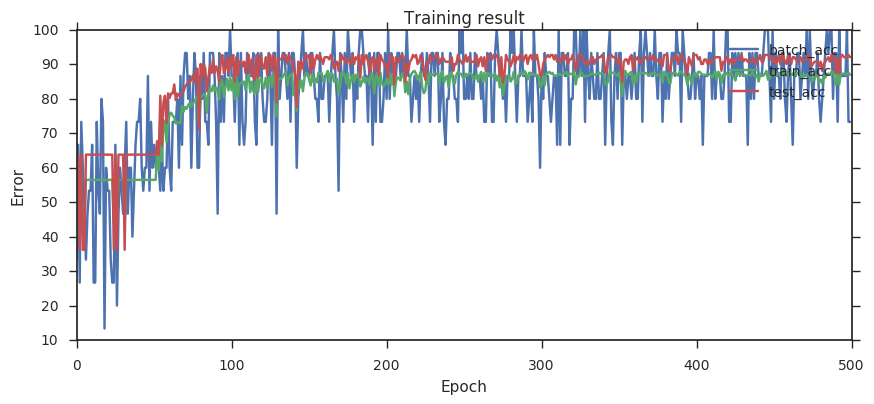

In [62]:
df = pd.DataFrame(data=results, columns = ["epoch", "batch_acc", "train_acc", "test_acc"])
df.set_index("epoch", drop=True, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
 
ax.plot(df)
ax.set(xlabel='Epoch',
       ylabel='Error',
       title='Training result')
 
ax.legend(df.columns, loc=1)

print "Maximum test accuracy: %.2f%%" % np.max(df["test_acc"])

### 5. Hyper-parameter tuning

While the model specification is correct, if you train the model using the previous hyper-parameters, the visualized results will not seem so promising. This can be for a number of reasons, including that the network is too deep or not deep enough, the learning rate is too fast or not fast enough, we are not training for enough epochs, our batch size is either too big or too small, or we can benefit from other regularization strategies such as dropout.

Infact, the tuning of hyper-parameters is one of the most difficult problems in applied machine learning, precisely since it is often not clear how these should be set at the outset. While there are some heuristic 'best practice' strategies out there that people have developed, for the most part researchers experiment with different settings for hyper-parameters until they get the results they want.

For the last part of the assignment, experiment with different settings for the hyper-parameters specified at the top of the lab. With different combinations of  parameters you should be able to achieve **at least 90% accuracy in the test set** without having to train the model for more than 500 epochs. Once you achieve this accuracy, save your edits and submit your work as a pull request back to the main project.